## Import Necessary Libraries

In [1]:
import pandas as pd
import os

import model_metrics

print(model_metrics.__version__)

from model_tuner import loadObjects

from ucimlrepo import fetch_ucirepo
from eda_toolkit import ensure_directory
from model_metrics import (
    summarize_model_performance,
    show_calibration_curve,
    show_confusion_matrix,
    show_roc_curve,
    show_pr_curve,
    show_lift_chart,
    show_gain_chart,
    show_ks_curve,
    plot_threshold_metrics,
)

0.0.2a


## Set Model Path

In [2]:
print(f"Model Metrics version: {model_metrics.__version__}")
print(f"Model Metrics authors: {model_metrics.__author__} \n")

## Define base paths
## `base_path`` represents the parent directory of your current working directory
base_path = os.path.join(os.pardir)
## Go up one level from 'notebooks' to the parent directory, then into the
## 'results' folder

model_path = os.path.join(os.pardir, "model_files/results")
data_path = os.path.join(os.pardir, "model_files")
image_path_png = os.path.join(data_path, "images", "png_images")
image_path_svg = os.path.join(data_path, "images", "svg_images")

# Use the function to ensure the 'data' directory exists
ensure_directory(model_path)
ensure_directory(image_path_png)
ensure_directory(image_path_svg)

Model Metrics version: 0.0.2a
Model Metrics authors: Leonid Shpaner 

Directory exists: ../model_files/results
Directory exists: ../model_files/images/png_images
Directory exists: ../model_files/images/svg_images


In [3]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Generate a synthetic dataset
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    random_state=3,
)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=3,
)

# Train models
model1 = LogisticRegression(random_state=3).fit(X_train, y_train)
model2 = RandomForestClassifier(random_state=3).fit(X_train, y_train)

model_titles = ["Logistic Regression", "Random Forest"]

AUC for Logistic Regression: 0.92
AUC for Random Forest: 0.99


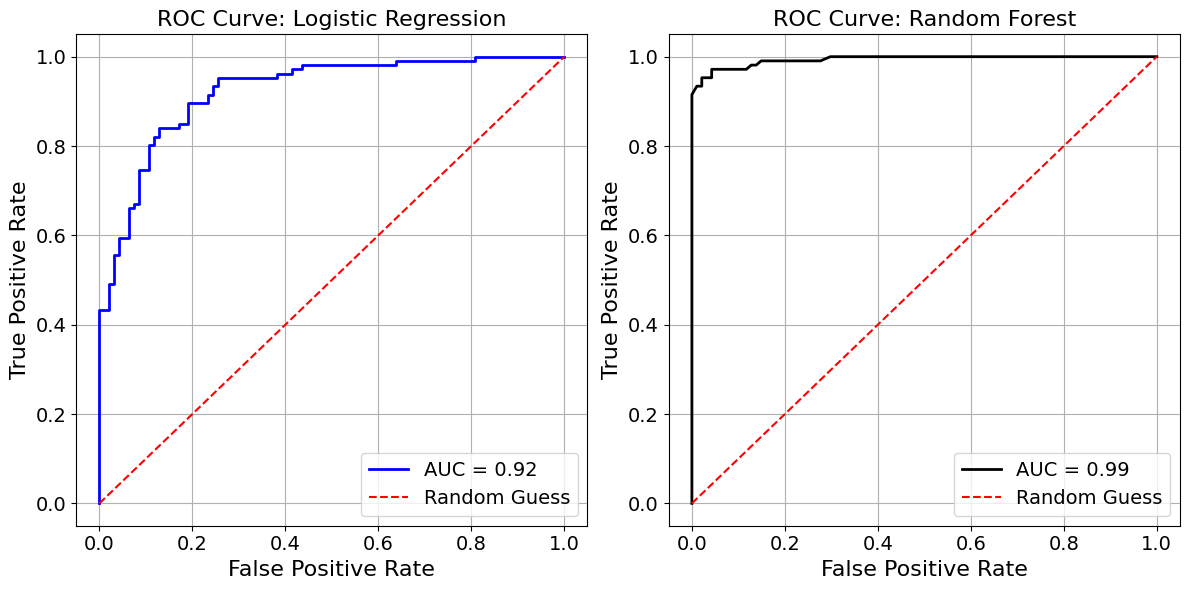

In [4]:
# Plot ROC curves
show_roc_curve(
    model=[model1, model2],
    X=X_test,
    y=y_test,
    model_title=model_titles,
    decimal_places=2,
    n_cols=2,
    n_rows=1,
    curve_kwgs={
        "Logistic Regression": {"color": "blue", "linewidth": 2},
        "Random Forest": {"color": "black", "linewidth": 2},
    },
    linestyle_kwgs={"color": "red", "linestyle": "--"},
    save_plot=True,
    grid=True,
    figsize=(12, 6),
    label_fontsize=16,
    tick_fontsize=14,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

AUC for Logistic Regression: 0.92
AUC for Random Forest: 0.99


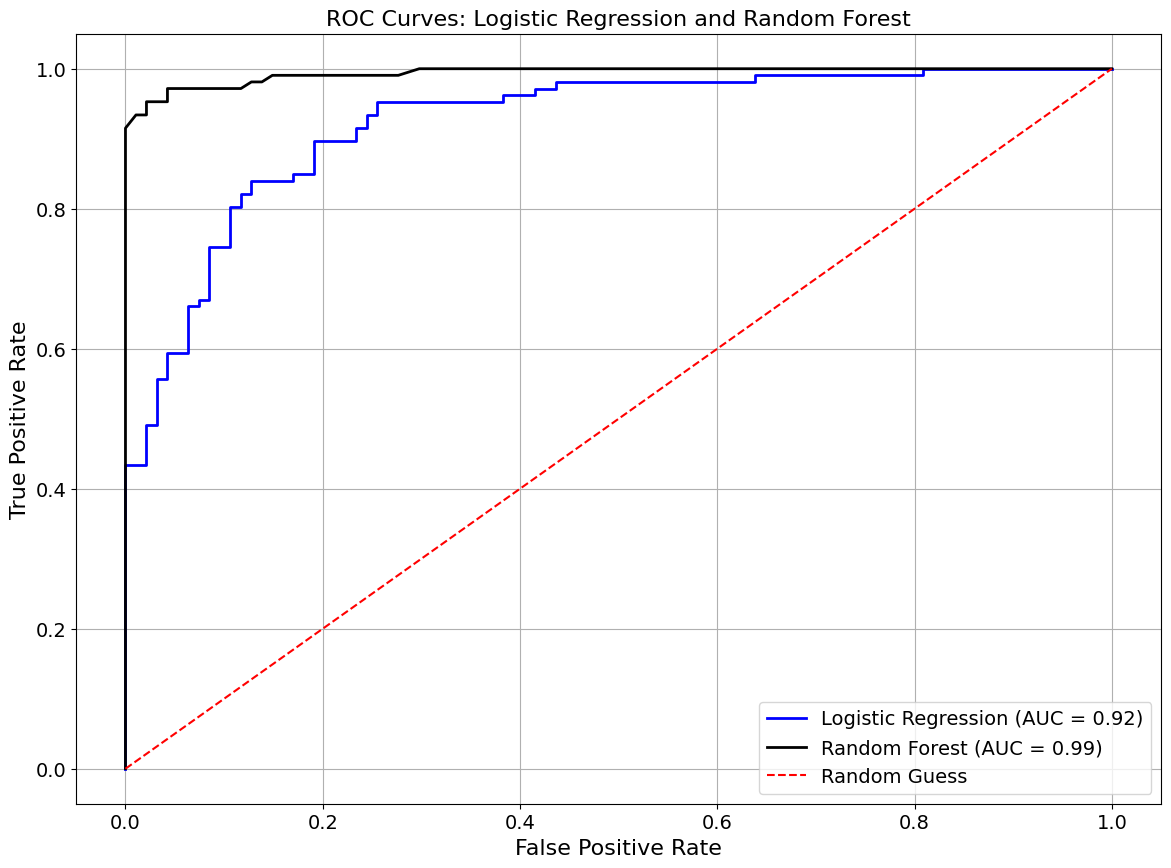

In [5]:
# Plot ROC curves
show_roc_curve(
    model=[model1, model2],
    X=X_test,
    y=y_test,
    model_title=model_titles,
    decimal_places=2,
    n_cols=2,
    n_rows=1,
    curve_kwgs={
        "Logistic Regression": {"color": "blue", "linewidth": 2},
        "Random Forest": {"color": "black", "linewidth": 2},
    },
    linestyle_kwgs={"color": "red", "linestyle": "--"},
    title="ROC Curves: Logistic Regression and Random Forest",
    save_plot=True,
    overlay=True,
    figsize=(14, 10),
    label_fontsize=16,
    tick_fontsize=14,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

Average Precision for Logistic Regression: 0.933
Average Precision for Random Forest: 0.995


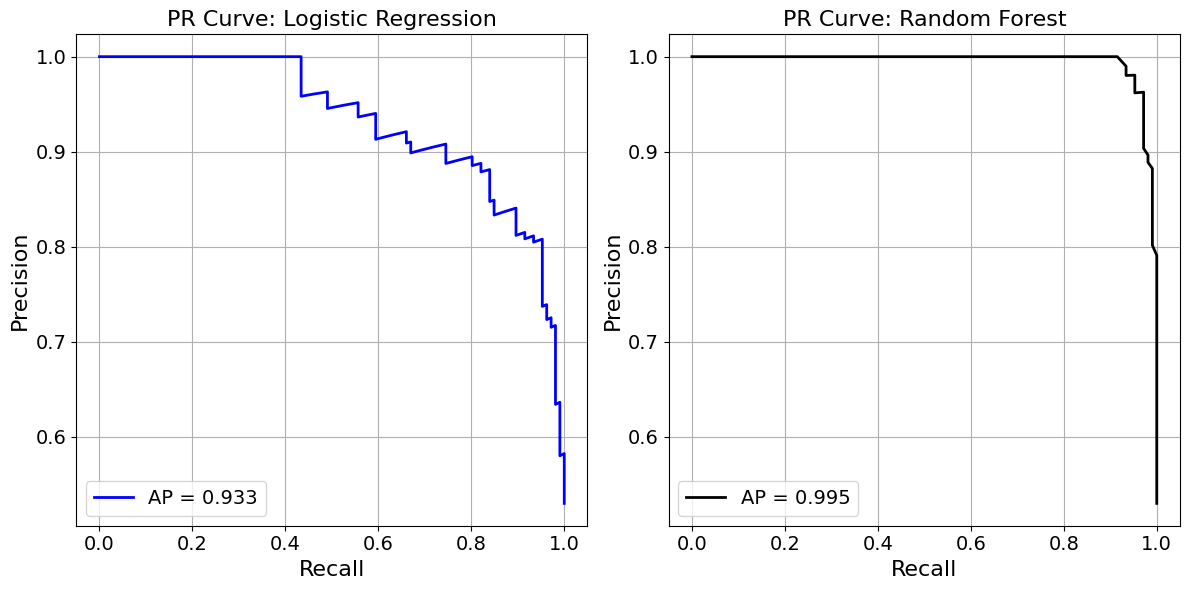

In [6]:
show_pr_curve(
    model=[model1, model2],
    X=X_test,
    y=y_test,
    # x_label="Hello",
    model_title=model_titles,
    decimal_places=3,
    curve_kwgs={
        "Logistic Regression": {"color": "blue", "linewidth": 2},
        "Random Forest": {"color": "black", "linewidth": 2},
    },
    overlay=False,
    n_cols=2,
    n_rows=1,
    grid=True,
    save_plot=True,
    figsize=(12, 6),
    label_fontsize=16,
    tick_fontsize=14,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

Average Precision for Logistic Regression: 0.93
Average Precision for Random Forest: 0.99


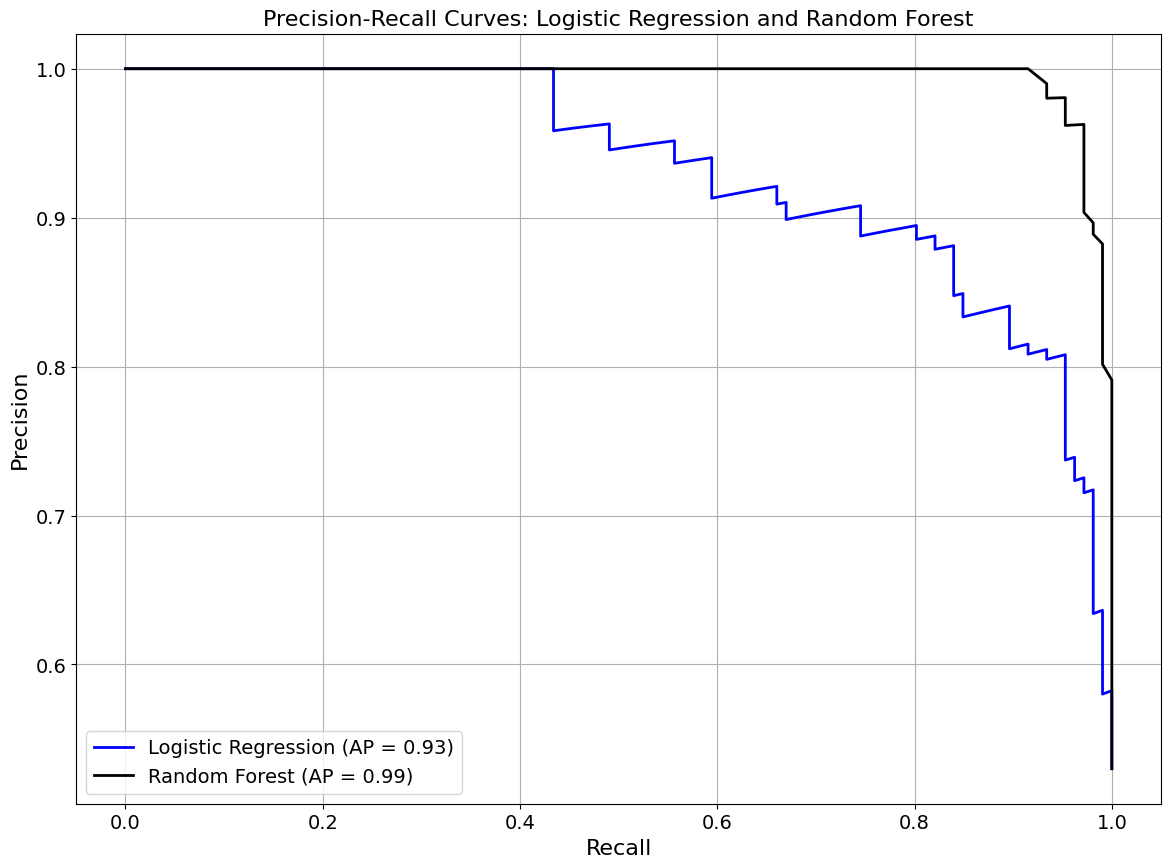

In [7]:
# Plot ROC curves
show_pr_curve(
    model=[model1, model2],
    X=X_test,
    y=y_test,
    model_title=model_titles,
    decimal_places=2,
    curve_kwgs={
        "Logistic Regression": {"color": "blue", "linewidth": 2},
        "Random Forest": {"color": "black", "linewidth": 2},
    },
    title="Precision-Recall Curves: Logistic Regression and Random Forest",
    save_plot=True,
    overlay=True,
    figsize=(14, 10),
    label_fontsize=16,
    tick_fontsize=14,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    # legend_metric="aucpr",
)

## Lift Chart

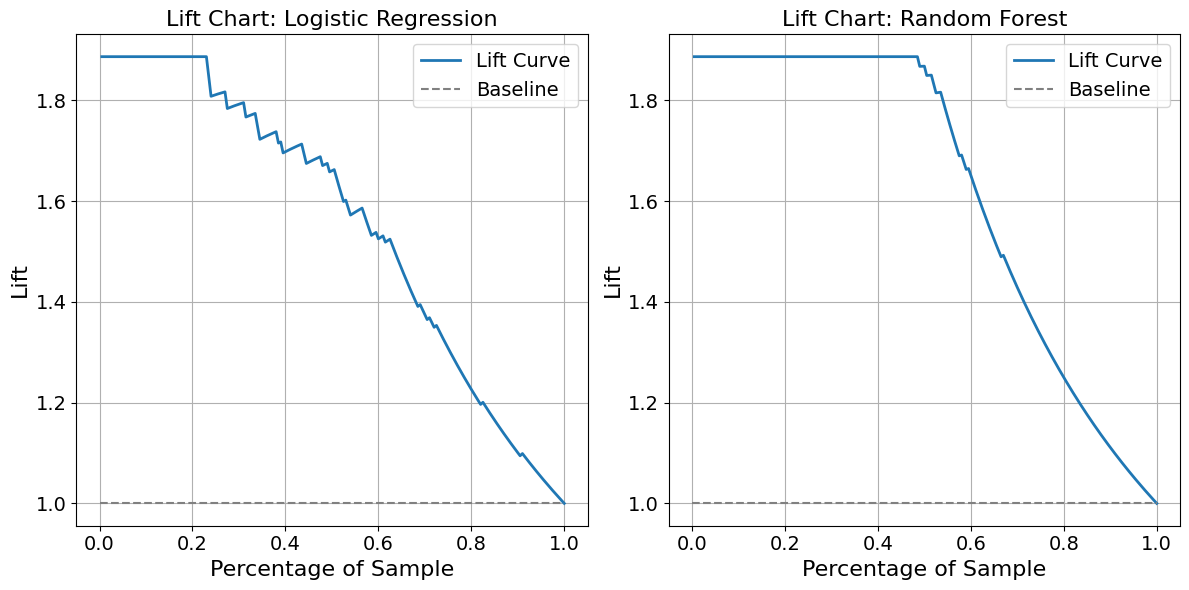

In [17]:
# Plot Lift chart
show_lift_chart(
    model=[model1, model2],
    X=X_test,
    y=y_test,
    overlay=False,
    model_title=["Logistic Regression", "Random Forest"],
    save_plot=True,
    linestyle_kwgs={"color": "grey", "linestyle": "--"},
    curve_kwgs={title: {"linewidth": 2} for title in model_titles},
    grid=True,
    figsize=(12, 6),
    label_fontsize=16,
    tick_fontsize=14,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

## Gain Chart

In [ ]:
# Plot Gain chart
show_gain_chart(
    model=pipelines_or_models,
    X=X_test,
    y=y_test,
    overlay=False,
    # title="Custom",
    model_title=model_titles,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    #     # "SVM": {"color": "red", "linestyle": "--", "linewidth": 1.5},
    # },
    # linestyle_kwgs={"color": "black", "linestyle": "-"},
    save_plot=True,
    grid=True,
    n_cols=3,
    figsize=(10, 4),
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

Confusion Matrix for Logistic Regression: 

          Predicted 0  Predicted 1
Actual 0           71           23
Actual 1            8           98

Classification Report for Logistic Regression: 

              precision    recall  f1-score   support

           0       0.90      0.76      0.82        94
           1       0.81      0.92      0.86       106

    accuracy                           0.84       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.85      0.84      0.84       200

Confusion Matrix for Random Forest: 

          Predicted 0  Predicted 1
Actual 0           81           13
Actual 1            2          104

Classification Report for Random Forest: 

              precision    recall  f1-score   support

           0       0.98      0.86      0.92        94
           1       0.89      0.98      0.93       106

    accuracy                           0.93       200
   macro avg       0.93      0.92      0.92       200
weighted avg   

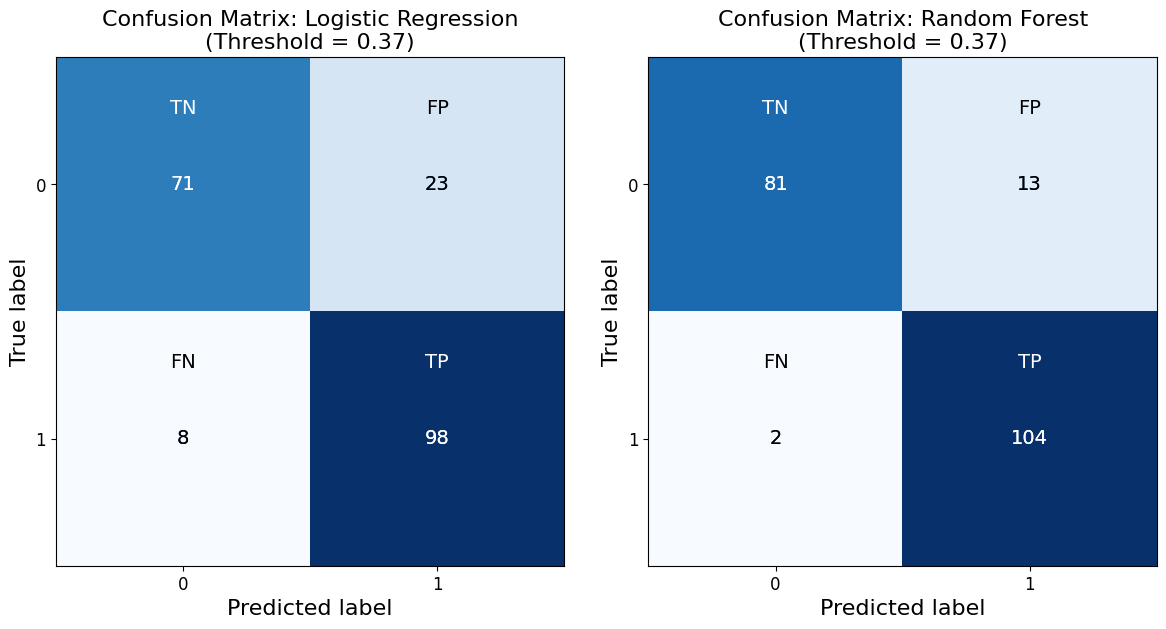

In [ ]:
show_confusion_matrix(
    model=[model1, model2],
    X=X_test,
    y=y_test,
    model_title=model_titles,
    # cmap="viridis",
    text_wrap=40,
    # title="Custom",
    save_plot=True,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    grid=True,
    n_cols=2,
    n_rows=1,
    figsize=(6, 6),
    show_colorbar=False,
    label_fontsize=16,
    tick_fontsize=12,
    inner_fontsize=14,
    class_report=True,
    custom_threshold=0.37,
    # custom_threshold=0.5,
    # labels=False,
)

Confusion Matrix for Logistic Regression: 

          Predicted 0  Predicted 1
Actual 0           76           18
Actual 1           13           93

Classification Report for Logistic Regression: 

              precision    recall  f1-score   support

           0       0.85      0.81      0.83        94
           1       0.84      0.88      0.86       106

    accuracy                           0.84       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.85      0.84      0.84       200

Confusion Matrix for Random Forest: 

          Predicted 0  Predicted 1
Actual 0           84           10
Actual 1            3          103

Classification Report for Random Forest: 

              precision    recall  f1-score   support

           0       0.97      0.89      0.93        94
           1       0.91      0.97      0.94       106

    accuracy                           0.94       200
   macro avg       0.94      0.93      0.93       200
weighted avg   

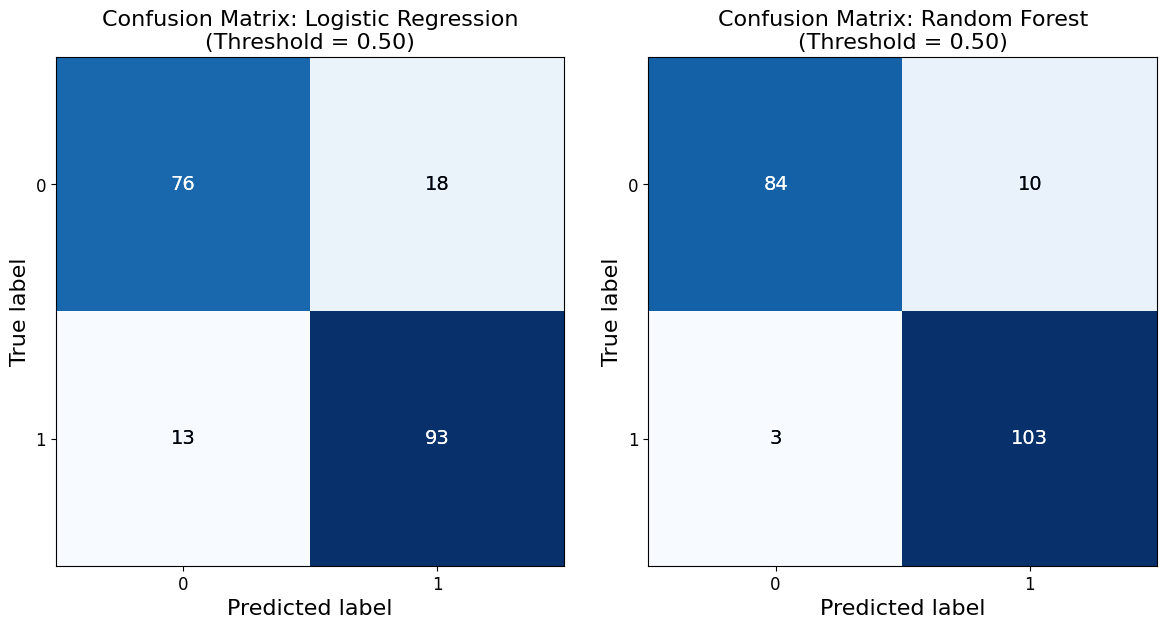

In [ ]:
show_confusion_matrix(
    model=[model1, model2],
    X=X_test,
    y=y_test,
    model_title=model_titles,
    cmap="Blues",
    text_wrap=40,
    # title="Custom",
    save_plot=True,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    grid=True,
    n_cols=2,
    n_rows=1,
    figsize=(6, 6),
    show_colorbar=False,
    label_fontsize=16,
    tick_fontsize=12,
    inner_fontsize=14,
    class_report=True,
    # custom_threshold=0.5,
    labels=False,
)

## UCI Census Income Dataset

## Load The Model Object and Test Data

In [ ]:
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features

In [ ]:
X.to_csv(os.path.join(data_path, "X.csv"))

In [ ]:
model_lr = loadObjects(os.path.join(model_path, "LogisticRegression.pkl"))
model_dt = loadObjects(os.path.join(model_path, "DecisionTreeClassifier.pkl"))
model_rf = loadObjects(os.path.join(model_path, "RandomForestClassifier.pkl"))


X_test = pd.read_parquet(os.path.join(data_path, "X_test.parquet"))
y_test = pd.read_parquet(os.path.join(data_path, "y_test.parquet"))

In [ ]:
X_test_2 = X_test.join(
    X[["sex", "race", "relationship", "occupation", "workclass", "education"]]
)

In [ ]:
X_test_2

## Set The Desired Naming Conventions

In [ ]:
pipelines_or_models = [
    model_lr["model"].estimator,
    model_rf["model"].estimator,
    model_dt["model"].estimator,
]

# Model titles
model_titles = [
    "Logistic Regression",
    "Random Forest Classifier",
    "Decision Tree Classifier",
]

## ROC AUC Curves

In [ ]:
model_titles = [
    "Logistic Regression",
    "Decision Tree Classifier",
    "Random Forest Classifier",
]

In [ ]:
# Plot ROC curves
show_roc_curve(
    model=pipelines_or_models,
    X=X_test,
    y=y_test,
    model_title=model_titles,
    decimal_places=2,
    n_cols=3,
    n_rows=1,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    # },
    linestyle_kwgs={"color": "red", "linestyle": "--"},
    save_plot=True,
    grid=True,
    text_wrap=20,
    figsize=(12, 4),
    label_fontsize=16,
    tick_fontsize=14,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

In [ ]:
# Plot ROC curves
show_roc_curve(
    # model=[model_dt["model"].estimator],
    model=pipelines_or_models,
    X=X_test,
    y=y_test,
    overlay=True,
    # title="Custom",
    # title = "",
    title=None,
    model_title=model_titles,
    decimal_places=2,
    # n_cols=3,
    # n_rows=1,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    # },
    # linestyle_kwgs={"color": "grey", "linestyle": "--"},
    save_plot=True,
    # grid=True,
    figsize=(11, 6),
    # label_fontsize=16,
    # tick_fontsize=16,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    # gridlines=False,
    # group_category=X_test_2["race"],
)

In [ ]:
# Plot ROC curves
show_roc_curve(
    model=pipelines_or_models,
    X=X_test,
    y=y_test,
    # overlay=True,
    # title="Custom",
    # title = "",
    title=None,
    model_title=model_titles,
    decimal_places=2,
    n_cols=3,
    # n_rows=1,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    # },
    # linestyle_kwgs={"color": "grey", "linestyle": "--"},
    save_plot=True,
    # grid=True,
    figsize=(10, 6),
    # label_fontsize=16,
    # tick_fontsize=16,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    # gridlines=False,
    group_category=X_test_2["race"],
)

In [ ]:
# Plot ROC curves
show_pr_curve(
    model=pipelines_or_models,
    X=X_test,
    y=y_test,
    overlay=False,
    # title="Custom",
    # title = "",
    title=None,
    model_title=model_titles,
    decimal_places=2,
    n_cols=3,
    # n_rows=1,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    # },
    # linestyle_kwgs={"color": "grey", "linestyle": "--"},
    save_plot=True,
    grid=False,
    # figsize=(8, 8),
    # label_fontsize=16,
    # tick_fontsize=16,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    # gridlines=False,
    group_category=X_test_2["race"],
    legend_metric="aucpr",
)

## Summarize Model Performance

In [ ]:
model_summary = summarize_model_performance(
    model=pipelines_or_models,
    X=X_test,
    y=y_test,
    model_title=model_titles,
    # model_threshold=thresholds,
    return_df=True,
    # decimal_places=6,
    # custom_threshold=0.7,
)

model_summary

In [ ]:
model_titles

In [ ]:
model_titles[1]

In [ ]:
# Example: Running KS Curve with a trained model
show_ks_curve(
    model=pipelines_or_models[0],  # Your trained model object
    X=X_test,  # Test dataset
    y=y_test,  # True labels
    title="Kolmogorov-Smirnov Curves",
    save_plot=False,
    text_wrap=50,
    curve_kwgs={"linewidth": 2},
    linestyle_kwgs={"color": "red", "linestyle": "--", "linewidth": 2},
    figsize=(8, 6),
    label_fontsize=12,
    model_title=model_titles,
    tick_fontsize=10,
    gridlines=True,
)

## Plot The Calibration Curve

In [ ]:
# Plot calibration curves in overlay mode
show_calibration_curve(
    model=pipelines_or_models[:2],
    X=X_test,
    y=y_test,
    model_title=model_titles[:2],
    text_wrap=50,
    figsize=(12, 6),
    label_fontsize=16,
    tick_fontsize=13,
    bins=10,
    show_brier_score=True,
    grid=True,
    linestyle_kwgs={"color": "black", "linewidth": 2},
    # title="",
    save_plot=True,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

In [ ]:
# Plot calibration curves in overlay mode
show_calibration_curve(
    # model=pipelines_or_models[2],
    model=pipelines_or_models,
    X=X_test,
    y=y_test,
    model_title=model_titles,
    # model_title=model_titles[2],
    overlay=True,
    text_wrap=50,
    figsize=(14, 10),
    label_fontsize=16,
    tick_fontsize=13,
    bins=10,
    show_brier_score=True,
    linestyle_kwgs={"color": "black", "linewidth": 2},
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    #     "Decision Tree": {"color": "blue", "linewidth": 2},
    #     "Random Forest": {"color": "blue", "linewidth": 2},
    # },
    curve_kwgs={title: {"linewidth": 2} for title in model_titles},
    save_plot=True,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    # title="",
)

In [ ]:
# Plot calibration curves in overlay mode
show_calibration_curve(
    model=pipelines_or_models[2],
    X=X_test,
    y=y_test,
    model_title=model_titles[2],
    figsize=(14, 10),
    label_fontsize=16,
    tick_fontsize=13,
    bins=10,
    show_brier_score=True,
    linestyle_kwgs={"color": "black"},
    curve_kwgs={title: {"linewidth": 2} for title in model_titles},
    group_category=X_test_2["race"],
    save_plot=True,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

## Plot The Confusion Matrix

In [ ]:
show_confusion_matrix(
    model=pipelines_or_models,
    X=X_test,
    y=y_test,
    model_titles=model_titles,
    cmap="Blues",
    text_wrap=40,
    # title="Custom",
    save_plot=True,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    grid=True,
    n_cols=3,
    n_rows=1,
    figsize=(4, 4),
    show_colorbar=False,
    label_fontsize=14,
    tick_fontsize=12,
    inner_fontsize=10,
    class_report=True,
    # custom_threshold=0.5,
    # labels=False,
)

## Plot ROC AUC Curve

In [ ]:
# Plot ROC curves
show_roc_curve(
    model=pipelines_or_models,
    X=X_test,
    y=y_test,
    overlay=False,
    # title="Custom",
    title=None,
    model_title=model_titles,
    decimal_places=6,
    n_cols=3,
    # n_rows=1,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    #     "SVM": {"color": "red", "linestyle": "--", "linewidth": 1.5},
    # },
    # linestyle_kwgs={"color": "grey", "linestyle": "--"},
    save_plot=True,
    grid=False,
    # figsize=(8, 6),
    # label_fontsize=16,
    # tick_fontsize=16,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    # gridlines=False,
    group_category=X_test_2["race"],
)

In [ ]:
# Plot ROC curves
show_pr_curve(
    model=pipelines_or_models,
    X=X_test,
    y=y_test,
    overlay=False,
    # title="Custom",
    title=None,
    model_title=model_titles,
    decimal_places=3,
    n_cols=3,
    # n_rows=1,
    # curve_kwgs={
    #     "Logistic Regression": {"color": "blue", "linewidth": 2},
    #     "SVM": {"color": "red", "linestyle": "--", "linewidth": 1.5},
    # },
    # linestyle_kwgs={"color": "grey", "linestyle": "--"},
    save_plot=True,
    grid=False,
    # figsize=(10, 10),
    # label_fontsize=16,
    # tick_fontsize=16,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    # gridlines=False,
    group_category=X_test_2["race"],
)

In [ ]:
X_test.columns.to_list()

## Precision-Recall Curve

In [ ]:
model_summary = summarize_model_performance(
    model=pipelines_or_models[0],
    X=X_test,
    y=y_test,
    model_title=model_titles,
    # model_threshold=thresholds,
    return_df=True,
    custom_threshold=0.7811,
)

model_summary

In [ ]:
# Example usage with a trained model
plot_threshold_metrics(
    pipelines_or_models[0],
    X_test,
    y_test,
    # figsize=(6, 6),
    # gridlines=False,
    baseline_thresh=False,
    baseline_kwgs={
        "color": "purple",
        "linestyle": "--",
        # "alpha": 0.7,
        "linewidth": 1,
    },
    curve_kwgs={
        "linestyle": "-",
        # "alpha": 0.1,
        "linewidth": 1.25,
    },
    lookup_metric="precision",
    lookup_value=0.879,
    # title="Threshold Metrics for Model X",
    # decimal_places=2,
    # label_fontsize=10,
    # tick_fontsize=8,
)